# **Generative Modeling** 

### Colorizing CIFAR-10 images with GAN

<pre>
Deep Learning with Python and Lua - Home Assignment 5

Author: <i>Nyikovics Máté</i>
2019.12.10.
</pre>

In [1]:
# using tensorflow 2.0 on colab
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras import layers
import time

from IPython import display

In [3]:
# importing the CIFAR-10 dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [4]:
train_images.shape

(50000, 32, 32, 3)

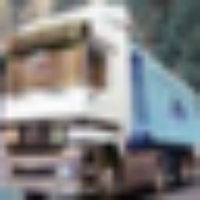

In [5]:
cv2_imshow(cv2.resize(train_images[1], (200,200)))

In [0]:
# converting the colored train images to grayscale
train_images_gray = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)[:,:,np.newaxis] for image in train_images], dtype=np.float32)

In [7]:
train_images_gray.shape

(50000, 32, 32, 1)

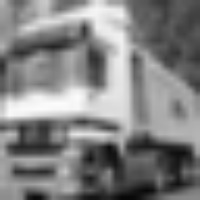

In [8]:
cv2_imshow(cv2.resize(train_images_gray[1], (200,200)))

### Network architecture

**[G]enerator network**
For the the generator network the input is a grayscale image and i'm using 3 sequential convolution blocks consisting of 2 conv2d layers each with the last one being relu activated to transform the image into a 3 channeled (RGB) one.

**[D]iscriminator network**
The discriminator network gets a colored (3 channeled) image and should return a value of the image being "rightly colored". (0: the image is wrongly colored, 1: image rightly colored)

![](https://raw.githubusercontent.com/pdrabinski/GAN_Colorizer/master/images/GAN_arch.png)

### Loss functions

Let y be a real color image and let x be a grayscale image, so that G(x) is a generated color image. Then the generator tries to minimize the following function:

**log(1 - D(G(x)))**

This function is equivalent to trying to maximize the probability that D confuses a fake color image for a real color image. Meanwhile discriminator tries to minimize the following function:

**-(log(D(y)) + log(1 - D(G(x))))**

Trying to minimize this function is equivalent to trying to maximize the probability that D assigns the value 1 to real color images and the value 0 to fake color images.

In [0]:
class Generator(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.input_ = tf.keras.layers.InputLayer(input_shape=(32, 32, 1))
        self.conv1 = tf.keras.layers.Conv2D(filters=3, kernel_size=3, strides=1, padding="same", activation="linear")
        self.conv2 = tf.keras.layers.Conv2D(filters=3, kernel_size=3, strides=1, padding="same", activation="relu")
        self.conv3 = tf.keras.layers.Conv2D(filters=9, kernel_size=3, strides=1, padding="same", activation="linear")
        self.conv4 = tf.keras.layers.Conv2D(filters=9, kernel_size=3, strides=1, padding="same", activation="relu")        
        self.conv5 = tf.keras.layers.Conv2D(filters=3, kernel_size=3, strides=1, padding="same", activation="linear")
        self.conv6 = tf.keras.layers.Conv2D(filters=3, kernel_size=3, strides=1, padding="same", activation="relu")
    
    @tf.function
    def call(self, inputs):
        x = self.input_(inputs)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        return x

In [0]:
class Discriminator(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.input_ = tf.keras.layers.InputLayer(input_shape=(32, 32, 3))
        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="linear")
        self.max_pool1 = tf.keras.layers.MaxPool2D()
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation="linear")
        self.max_pool2 = tf.keras.layers.MaxPool2D()
        self.conv3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same", activation="linear")
        self.max_pool3 = tf.keras.layers.MaxPool2D()
        self.conv4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding="same", activation="linear")
        self.max_pool4 = tf.keras.layers.MaxPool2D()
        self.flatten = tf.keras.layers.Flatten()
        self.dense2 = tf.keras.layers.Dense(units=1, activation="linear")
    
    @tf.function
    def call(self, inputs):
        x = self.input_(inputs)
        x = self.conv1(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        x = self.conv3(x)
        x = self.max_pool3(x)
        x = self.flatten(x)
        x = self.dense2(x)
        eps = tf.constant(1e-6, dtype=tf.float32)
        return tf.clip_by_value(x, 0+eps, 1-eps)    # clipping the values slightly to be able to safely calculate the logarithms later

In [0]:
def generator(batch_size: int) -> np.array:
    """
    Yields batch_size-d randomly selected colored images and their grayscale counterparts. Image data range [0,1] 
    """
    gray = np.zeros(shape=(batch_size, 32, 32, 1), dtype=np.float32)
    color = np.zeros(shape=(batch_size, 32, 32, 3), dtype=np.float32)
    while True: 
        indexes = np.random.randint(0, train_images.shape[0], batch_size)
        for i, idx in enumerate(indexes):
            gray[i] = train_images_gray[idx]
            color[i] = train_images[idx]
        
        yield gray / 255, color / 255


In [0]:
@tf.function
def loss_generator(x):
    return tf.math.log(1-x)

@tf.function
def loss_discriminator(x,y):
    return -(tf.math.log(x) + tf.math.log(1-y)) 

epoch 0
gen loss: -1.0357095003128052
disc loss: 928.2269287109375
epoch 1
gen loss: -1.3674453496932983
disc loss: 852.5062866210938
epoch 2
gen loss: -1.5433666706085205
disc loss: 857.0272216796875
epoch 3
gen loss: -1.918270230293274
disc loss: 807.4334106445312
epoch 4
gen loss: -2.240840435028076
disc loss: 762.0673828125
epoch 5
gen loss: -2.4600539207458496
disc loss: 716.4149780273438
epoch 6
gen loss: -2.6597402095794678
disc loss: 695.7962646484375
epoch 7
gen loss: -3.1029107570648193
disc loss: 681.693359375
epoch 8
gen loss: -3.3162569999694824
disc loss: 641.5255126953125
epoch 9
gen loss: -3.600468158721924
disc loss: 622.7828369140625
epoch 10
gen loss: -3.960057258605957
disc loss: 617.7066040039062
epoch 11
gen loss: -4.091240406036377
disc loss: 584.165283203125
epoch 12
gen loss: -4.460865497589111
disc loss: 565.8541259765625
epoch 13
gen loss: -4.886114597320557
disc loss: 542.6671752929688
epoch 14
gen loss: -4.9539971351623535
disc loss: 521.2163696289062
epoch

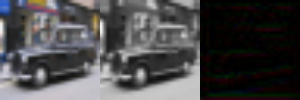

epoch 101
gen loss: -19.353755950927734
disc loss: 57.05848693847656
epoch 102
gen loss: -19.77518653869629
disc loss: 55.35579299926758
epoch 103
gen loss: -19.407825469970703
disc loss: 56.98711395263672
epoch 104
gen loss: -19.47568130493164
disc loss: 53.595298767089844
epoch 105
gen loss: -19.946840286254883
disc loss: 51.66962814331055
epoch 106
gen loss: -19.536468505859375
disc loss: 51.80097198486328
epoch 107
gen loss: -19.692167282104492
disc loss: 51.7633056640625
epoch 108
gen loss: -19.658973693847656
disc loss: 51.925052642822266
epoch 109
gen loss: -19.638002395629883
disc loss: 54.50974655151367
epoch 110
gen loss: -19.801433563232422
disc loss: 44.481849670410156
epoch 111
gen loss: -19.805286407470703
disc loss: 56.634765625
epoch 112
gen loss: -19.909414291381836
disc loss: 46.19500732421875
epoch 113
gen loss: -19.640178680419922
disc loss: 46.7057991027832
epoch 114
gen loss: -19.710830688476562
disc loss: 52.83006286621094
epoch 115
gen loss: -20.238407135009766


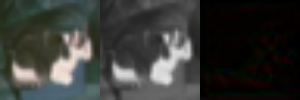

epoch 201
gen loss: -18.00084114074707
disc loss: 31.956878662109375
epoch 202
gen loss: -18.135488510131836
disc loss: 29.623058319091797
epoch 203
gen loss: -18.179100036621094
disc loss: 35.76520919799805
epoch 204
gen loss: -18.41451644897461
disc loss: 34.68049621582031
epoch 205
gen loss: -17.620508193969727
disc loss: 30.05554962158203
epoch 206
gen loss: -18.05442237854004
disc loss: 33.82920455932617
epoch 207
gen loss: -18.16887664794922
disc loss: 31.75665283203125
epoch 208
gen loss: -18.416671752929688
disc loss: 28.875024795532227
epoch 209
gen loss: -18.350868225097656
disc loss: 30.501556396484375
epoch 210
gen loss: -17.86492347717285
disc loss: 33.22321319580078
epoch 211
gen loss: -17.740478515625
disc loss: 30.993471145629883
epoch 212
gen loss: -17.7694091796875
disc loss: 29.242612838745117
epoch 213
gen loss: -17.46706771850586
disc loss: 31.0969181060791
epoch 214
gen loss: -17.73828887939453
disc loss: 30.375986099243164
epoch 215
gen loss: -17.946626663208008


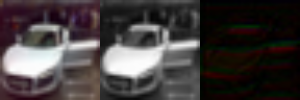

epoch 301
gen loss: -13.921232223510742
disc loss: 22.727930068969727
epoch 302
gen loss: -13.277305603027344
disc loss: 29.299339294433594
epoch 303
gen loss: -14.049152374267578
disc loss: 24.979827880859375
epoch 304
gen loss: -14.41546630859375
disc loss: 21.76296615600586
epoch 305
gen loss: -13.87972354888916
disc loss: 25.894506454467773
epoch 306
gen loss: -14.426851272583008
disc loss: 25.98731231689453
epoch 307
gen loss: -14.303922653198242
disc loss: 20.491073608398438
epoch 308
gen loss: -13.689419746398926
disc loss: 25.664493560791016
epoch 309
gen loss: -13.304092407226562
disc loss: 28.285358428955078
epoch 310
gen loss: -14.118725776672363
disc loss: 22.25713348388672
epoch 311
gen loss: -13.307428359985352
disc loss: 23.6735782623291
epoch 312
gen loss: -13.580155372619629
disc loss: 22.677173614501953
epoch 313
gen loss: -13.922280311584473
disc loss: 24.636980056762695
epoch 314
gen loss: -13.717394828796387
disc loss: 22.15768051147461
epoch 315
gen loss: -12.7679

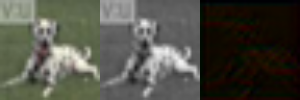

epoch 401
gen loss: -10.468335151672363
disc loss: 22.482208251953125
epoch 402
gen loss: -10.915712356567383
disc loss: 22.650793075561523
epoch 403
gen loss: -9.820892333984375
disc loss: 18.604162216186523
epoch 404
gen loss: -10.497654914855957
disc loss: 24.410524368286133
epoch 405
gen loss: -10.332816123962402
disc loss: 24.841777801513672
epoch 406
gen loss: -10.080694198608398
disc loss: 21.409683227539062
epoch 407
gen loss: -10.161149024963379
disc loss: 23.91152572631836
epoch 408
gen loss: -10.377331733703613
disc loss: 20.898216247558594
epoch 409
gen loss: -10.075642585754395
disc loss: 26.988330841064453
epoch 410
gen loss: -10.246420860290527
disc loss: 21.719871520996094
epoch 411
gen loss: -10.742431640625
disc loss: 22.252235412597656
epoch 412
gen loss: -10.846990585327148
disc loss: 19.583873748779297
epoch 413
gen loss: -9.869290351867676
disc loss: 21.872859954833984
epoch 414
gen loss: -10.785486221313477
disc loss: 24.35655403137207
epoch 415
gen loss: -9.5495

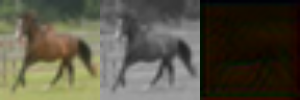

epoch 501
gen loss: -7.794124603271484
disc loss: 18.34748649597168
epoch 502
gen loss: -7.02207088470459
disc loss: 24.402563095092773
epoch 503
gen loss: -6.240528106689453
disc loss: 16.64164924621582
epoch 504
gen loss: -6.6686296463012695
disc loss: 17.272062301635742
epoch 505
gen loss: -6.249340534210205
disc loss: 21.449800491333008
epoch 506
gen loss: -6.265626907348633
disc loss: 19.25924301147461
epoch 507
gen loss: -7.249698162078857
disc loss: 17.164260864257812
epoch 508
gen loss: -6.248723983764648
disc loss: 18.134918212890625
epoch 509
gen loss: -7.382980823516846
disc loss: 15.794721603393555
epoch 510
gen loss: -6.906897068023682
disc loss: 19.516361236572266
epoch 511
gen loss: -7.4317803382873535
disc loss: 15.625475883483887
epoch 512
gen loss: -6.744771480560303
disc loss: 21.279298782348633
epoch 513
gen loss: -7.306392669677734
disc loss: 19.536710739135742
epoch 514
gen loss: -6.111588478088379
disc loss: 21.642776489257812
epoch 515
gen loss: -6.2452898025512

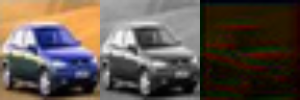

epoch 601
gen loss: -3.8349952697753906
disc loss: 18.69477081298828
epoch 602
gen loss: -4.065337181091309
disc loss: 15.282405853271484
epoch 603
gen loss: -3.7479147911071777
disc loss: 13.507494926452637
epoch 604
gen loss: -3.8551478385925293
disc loss: 15.593360900878906
epoch 605
gen loss: -3.8352320194244385
disc loss: 14.24789810180664
epoch 606
gen loss: -3.913341522216797
disc loss: 16.391151428222656
epoch 607
gen loss: -3.984931230545044
disc loss: 18.22915267944336
epoch 608
gen loss: -3.5587875843048096
disc loss: 19.616504669189453
epoch 609
gen loss: -4.00657320022583
disc loss: 13.398870468139648
epoch 610
gen loss: -3.96795654296875
disc loss: 12.083364486694336
epoch 611
gen loss: -4.1164140701293945
disc loss: 13.281259536743164
epoch 612
gen loss: -3.987725019454956
disc loss: 14.14747428894043
epoch 613
gen loss: -3.746432304382324
disc loss: 16.48950958251953
epoch 614
gen loss: -3.4019622802734375
disc loss: 13.138252258300781
epoch 615
gen loss: -3.47314023971

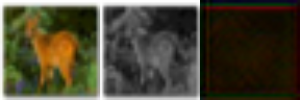

epoch 701
gen loss: -1.99937105178833
disc loss: 13.7498140335083
epoch 702
gen loss: -2.372319459915161
disc loss: 12.190753936767578
epoch 703
gen loss: -2.366239547729492
disc loss: 10.651097297668457
epoch 704
gen loss: -2.539693593978882
disc loss: 11.437227249145508
epoch 705
gen loss: -2.598238468170166
disc loss: 10.320884704589844
epoch 706
gen loss: -2.70224928855896
disc loss: 8.748584747314453
epoch 707
gen loss: -2.535761594772339
disc loss: 11.237150192260742
epoch 708
gen loss: -1.8978002071380615
disc loss: 10.99503231048584
epoch 709
gen loss: -2.830227851867676
disc loss: 12.446256637573242
epoch 710
gen loss: -2.2840654850006104
disc loss: 10.391940116882324
epoch 711
gen loss: -2.073214292526245
disc loss: 9.03139877319336
epoch 712
gen loss: -2.3793764114379883
disc loss: 11.058760643005371
epoch 713
gen loss: -1.9404593706130981
disc loss: 11.02495002746582
epoch 714
gen loss: -2.001098871231079
disc loss: 15.05936336517334
epoch 715
gen loss: -2.2643933296203613


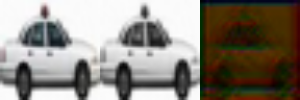

epoch 801
gen loss: -1.4337700605392456
disc loss: 8.792372703552246
epoch 802
gen loss: -1.5012693405151367
disc loss: 9.34485149383545
epoch 803
gen loss: -1.8407477140426636
disc loss: 8.048876762390137
epoch 804
gen loss: -1.729907512664795
disc loss: 6.3966474533081055
epoch 805
gen loss: -1.7987321615219116
disc loss: 6.091126918792725
epoch 806
gen loss: -1.647428035736084
disc loss: 6.89757776260376
epoch 807
gen loss: -1.7881108522415161
disc loss: 11.832840919494629
epoch 808
gen loss: -1.7347391843795776
disc loss: 10.145257949829102
epoch 809
gen loss: -1.647918939590454
disc loss: 9.80073070526123
epoch 810
gen loss: -1.1070669889450073
disc loss: 9.943525314331055
epoch 811
gen loss: -1.555462121963501
disc loss: 13.225883483886719
epoch 812
gen loss: -1.1920673847198486
disc loss: 13.779900550842285
epoch 813
gen loss: -1.6294803619384766
disc loss: 8.799276351928711
epoch 814
gen loss: -1.4793117046356201
disc loss: 11.791448593139648
epoch 815
gen loss: -1.453836917877

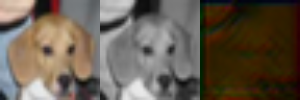

epoch 901
gen loss: -1.499949336051941
disc loss: 8.373652458190918
epoch 902
gen loss: -1.0432864427566528
disc loss: 11.949150085449219
epoch 903
gen loss: -1.4930150508880615
disc loss: 9.518272399902344
epoch 904
gen loss: -1.2500970363616943
disc loss: 8.844196319580078
epoch 905
gen loss: -1.3742550611495972
disc loss: 8.48926067352295
epoch 906
gen loss: -1.1417546272277832
disc loss: 9.439513206481934
epoch 907
gen loss: -1.3246468305587769
disc loss: 11.169286727905273
epoch 908
gen loss: -1.1954224109649658
disc loss: 8.28420639038086
epoch 909
gen loss: -1.2320735454559326
disc loss: 8.554969787597656
epoch 910
gen loss: -1.390479564666748
disc loss: 6.958975791931152
epoch 911
gen loss: -1.4912554025650024
disc loss: 7.213389873504639
epoch 912
gen loss: -1.1176159381866455
disc loss: 7.451661109924316
epoch 913
gen loss: -1.115393877029419
disc loss: 7.210655212402344
epoch 914
gen loss: -1.372524619102478
disc loss: 8.604097366333008
epoch 915
gen loss: -1.250162601470947

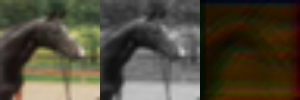

epoch 1001
gen loss: -1.2410881519317627
disc loss: 10.246626853942871
epoch 1002
gen loss: -1.2491084337234497
disc loss: 4.846077919006348
epoch 1003
gen loss: -1.144317865371704
disc loss: 6.912547588348389
epoch 1004
gen loss: -1.248570203781128
disc loss: 5.052272796630859
epoch 1005
gen loss: -0.9786622524261475
disc loss: 6.357193946838379
epoch 1006
gen loss: -1.10395085811615
disc loss: 7.937539100646973
epoch 1007
gen loss: -1.1764156818389893
disc loss: 4.1304030418396
epoch 1008
gen loss: -1.31553053855896
disc loss: 6.6258544921875
epoch 1009
gen loss: -1.0943174362182617
disc loss: 4.863076210021973
epoch 1010
gen loss: -1.0360239744186401
disc loss: 10.74072265625
epoch 1011
gen loss: -1.0891623497009277
disc loss: 5.83495569229126
epoch 1012
gen loss: -1.0421291589736938
disc loss: 12.814142227172852
epoch 1013
gen loss: -1.0559601783752441
disc loss: 7.60782527923584
epoch 1014
gen loss: -1.2897346019744873
disc loss: 4.551502227783203
epoch 1015
gen loss: -1.031044602

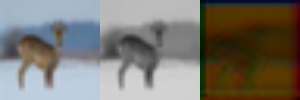

epoch 1101
gen loss: -1.0369830131530762
disc loss: 6.7895941734313965
epoch 1102
gen loss: -1.1443958282470703
disc loss: 6.349823951721191
epoch 1103
gen loss: -0.8465932011604309
disc loss: 20.252389907836914
epoch 1104
gen loss: -1.2260878086090088
disc loss: 6.44314432144165
epoch 1105
gen loss: -1.0883694887161255
disc loss: 10.856679916381836
epoch 1106
gen loss: -0.8008179068565369
disc loss: 5.214720726013184
epoch 1107
gen loss: -1.06792151927948
disc loss: 9.274134635925293
epoch 1108
gen loss: -1.0336452722549438
disc loss: 2.5868642330169678
epoch 1109
gen loss: -0.8866761326789856
disc loss: 6.907415390014648
epoch 1110
gen loss: -1.173582911491394
disc loss: 6.936471939086914
epoch 1111
gen loss: -1.175414800643921
disc loss: 10.91185188293457
epoch 1112
gen loss: -1.5284547805786133
disc loss: 8.3582124710083
epoch 1113
gen loss: -1.2092020511627197
disc loss: 8.922286987304688
epoch 1114
gen loss: -1.4465757608413696
disc loss: 5.71004056930542
epoch 1115
gen loss: -1.

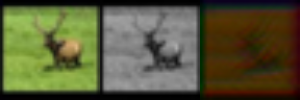

epoch 1201
gen loss: -1.0923429727554321
disc loss: 8.975770950317383
epoch 1202
gen loss: -1.3939167261123657
disc loss: 6.370680332183838
epoch 1203
gen loss: -2.005706787109375
disc loss: 5.972689628601074
epoch 1204
gen loss: -1.2985860109329224
disc loss: 8.102203369140625
epoch 1205
gen loss: -0.9581925868988037
disc loss: 8.908894538879395
epoch 1206
gen loss: -1.150807499885559
disc loss: 5.4200005531311035
epoch 1207
gen loss: -1.4381033182144165
disc loss: 9.042258262634277
epoch 1208
gen loss: -1.4581844806671143
disc loss: 8.578567504882812
epoch 1209
gen loss: -1.3147317171096802
disc loss: 9.219698905944824
epoch 1210
gen loss: -1.533444881439209
disc loss: 18.998342514038086
epoch 1211
gen loss: -1.557342290878296
disc loss: 11.16047477722168
epoch 1212
gen loss: -1.2897422313690186
disc loss: 8.841712951660156
epoch 1213
gen loss: -1.458816409111023
disc loss: 8.694262504577637
epoch 1214
gen loss: -1.654137372970581
disc loss: 10.3516206741333
epoch 1215
gen loss: -1.0

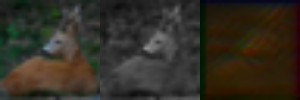

epoch 1301
gen loss: -1.5260095596313477
disc loss: 23.717260360717773
epoch 1302
gen loss: -1.945451021194458
disc loss: 11.013199806213379
epoch 1303
gen loss: -2.3642868995666504
disc loss: 14.11825180053711
epoch 1304
gen loss: -3.4671812057495117
disc loss: 12.888153076171875
epoch 1305
gen loss: -3.045210599899292
disc loss: 15.800529479980469
epoch 1306
gen loss: -2.9458160400390625
disc loss: 11.813968658447266
epoch 1307
gen loss: -3.5142157077789307
disc loss: 12.770889282226562
epoch 1308
gen loss: -3.288883686065674
disc loss: 11.103931427001953
epoch 1309
gen loss: -3.467564821243286
disc loss: 12.263872146606445
epoch 1310
gen loss: -1.8449978828430176
disc loss: 9.133938789367676
epoch 1311
gen loss: -2.122856616973877
disc loss: 12.192036628723145
epoch 1312
gen loss: -2.9751784801483154
disc loss: 11.569488525390625
epoch 1313
gen loss: -2.9620985984802246
disc loss: 9.335990905761719
epoch 1314
gen loss: -2.2998595237731934
disc loss: 12.316219329833984
epoch 1315
gen

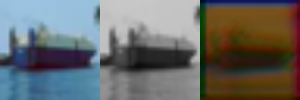

epoch 1401
gen loss: -3.4857218265533447
disc loss: 19.617843627929688
epoch 1402
gen loss: -3.2150278091430664
disc loss: 33.086021423339844
epoch 1403
gen loss: -3.7504584789276123
disc loss: 31.361459732055664
epoch 1404
gen loss: -3.4843289852142334
disc loss: 17.853717803955078
epoch 1405
gen loss: -2.8083863258361816
disc loss: 18.960065841674805
epoch 1406
gen loss: -3.124998092651367
disc loss: 49.61796569824219
epoch 1407
gen loss: -4.2913665771484375
disc loss: 23.974342346191406
epoch 1408
gen loss: -5.2519965171813965
disc loss: 22.56410026550293
epoch 1409
gen loss: -3.9018495082855225
disc loss: 32.458396911621094
epoch 1410
gen loss: -4.124233245849609
disc loss: 30.1767578125
epoch 1411
gen loss: -3.742133855819702
disc loss: 47.17287063598633
epoch 1412
gen loss: -4.4363112449646
disc loss: 40.71269989013672
epoch 1413
gen loss: -4.721858978271484
disc loss: 24.20867919921875
epoch 1414
gen loss: -6.028636455535889
disc loss: 22.850168228149414
epoch 1415
gen loss: -4.

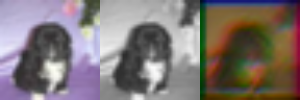

epoch 1501
gen loss: -13.163293838500977
disc loss: 85.31023406982422
epoch 1502
gen loss: -15.148695945739746
disc loss: 77.45404052734375
epoch 1503
gen loss: -12.342576026916504
disc loss: 137.19688415527344
epoch 1504
gen loss: -11.850512504577637
disc loss: 81.25091552734375
epoch 1505
gen loss: -15.822869300842285
disc loss: 99.95109558105469
epoch 1506
gen loss: -12.234580993652344
disc loss: 92.97216796875
epoch 1507
gen loss: -14.001541137695312
disc loss: 90.96797180175781
epoch 1508
gen loss: -15.986319541931152
disc loss: 66.91779327392578
epoch 1509
gen loss: -16.984189987182617
disc loss: 74.54605102539062
epoch 1510
gen loss: -16.022695541381836
disc loss: 114.37499237060547
epoch 1511
gen loss: -13.12959098815918
disc loss: 92.82159423828125
epoch 1512
gen loss: -14.390508651733398
disc loss: 93.04630279541016
epoch 1513
gen loss: -11.73542594909668
disc loss: 88.11199951171875
epoch 1514
gen loss: -13.864741325378418
disc loss: 91.9976806640625
epoch 1515
gen loss: -13

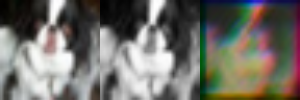

epoch 1601
gen loss: -58.18015670776367
disc loss: 213.45904541015625
epoch 1602
gen loss: -51.45073318481445
disc loss: 286.5857849121094
epoch 1603
gen loss: -45.48251724243164
disc loss: 216.02407836914062
epoch 1604
gen loss: -41.990604400634766
disc loss: 167.389404296875
epoch 1605
gen loss: -69.84698486328125
disc loss: 273.5200500488281
epoch 1606
gen loss: -96.99681854248047
disc loss: 253.16571044921875
epoch 1607
gen loss: -124.89537048339844
disc loss: 265.98150634765625
epoch 1608
gen loss: -151.30035400390625
disc loss: 252.58135986328125
epoch 1609
gen loss: -179.29107666015625
disc loss: 307.774658203125
epoch 1610
gen loss: -210.5381622314453
disc loss: 293.15966796875
epoch 1611
gen loss: -244.96311950683594
disc loss: 310.5254211425781
epoch 1612
gen loss: -261.4254150390625
disc loss: 325.96148681640625
epoch 1613
gen loss: -279.0285339355469
disc loss: 352.2872009277344
epoch 1614
gen loss: -302.3070983886719
disc loss: 370.94952392578125
epoch 1615
gen loss: -342.

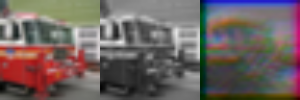

epoch 1701
gen loss: -218.54791259765625
disc loss: 490.8544616699219
epoch 1702
gen loss: -224.0227508544922
disc loss: 459.1341857910156
epoch 1703
gen loss: -216.23497009277344
disc loss: 405.7846984863281
epoch 1704
gen loss: -225.87095642089844
disc loss: 548.3204956054688
epoch 1705
gen loss: -242.28485107421875
disc loss: 451.5770263671875
epoch 1706
gen loss: -220.17694091796875
disc loss: 448.6244201660156
epoch 1707
gen loss: -229.6620635986328
disc loss: 564.0911865234375
epoch 1708
gen loss: -224.90113830566406
disc loss: 458.8154296875
epoch 1709
gen loss: -221.18331909179688
disc loss: 486.9415283203125
epoch 1710
gen loss: -229.99447631835938
disc loss: 442.96630859375
epoch 1711
gen loss: -227.8507080078125
disc loss: 504.98516845703125
epoch 1712
gen loss: -223.6031036376953
disc loss: 420.6444396972656
epoch 1713
gen loss: -235.31088256835938
disc loss: 480.84454345703125
epoch 1714
gen loss: -230.9474639892578
disc loss: 440.47259521484375
epoch 1715
gen loss: -228.0

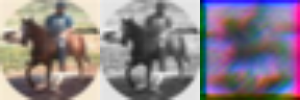

epoch 1801
gen loss: -123.662841796875
disc loss: 792.3724365234375
epoch 1802
gen loss: -100.85667419433594
disc loss: 985.0075073242188
epoch 1803
gen loss: -93.8675537109375
disc loss: 1104.2701416015625
epoch 1804
gen loss: -86.89824676513672
disc loss: 822.5928344726562
epoch 1805
gen loss: -95.88758850097656
disc loss: 887.19091796875
epoch 1806
gen loss: -81.71047973632812
disc loss: 939.1778564453125
epoch 1807
gen loss: -78.01702117919922
disc loss: 960.005615234375
epoch 1808
gen loss: -73.81517028808594
disc loss: 890.9547119140625
epoch 1809
gen loss: -77.18812561035156
disc loss: 828.2700805664062
epoch 1810
gen loss: -80.57395935058594
disc loss: 878.353759765625
epoch 1811
gen loss: -79.89322662353516
disc loss: 899.6967163085938
epoch 1812
gen loss: -70.00836944580078
disc loss: 961.502197265625
epoch 1813
gen loss: -81.6854248046875
disc loss: 929.5848999023438
epoch 1814
gen loss: -80.87428283691406
disc loss: 838.3270263671875
epoch 1815
gen loss: -87.53665924072266


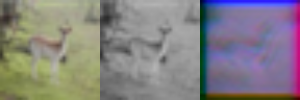

epoch 1901
gen loss: -240.472900390625
disc loss: 576.5948486328125
epoch 1902
gen loss: -238.49330139160156
disc loss: 525.9737548828125
epoch 1903
gen loss: -226.6215362548828
disc loss: 529.4281616210938
epoch 1904
gen loss: -232.28773498535156
disc loss: 578.0662841796875
epoch 1905
gen loss: -253.3604736328125
disc loss: 629.511474609375
epoch 1906
gen loss: -260.7290954589844
disc loss: 558.494384765625
epoch 1907
gen loss: -225.59393310546875
disc loss: 576.5872802734375
epoch 1908
gen loss: -230.06649780273438
disc loss: 551.5914306640625
epoch 1909
gen loss: -227.55184936523438
disc loss: 542.0361328125
epoch 1910
gen loss: -232.50411987304688
disc loss: 539.6859130859375
epoch 1911
gen loss: -225.32455444335938
disc loss: 539.5656127929688
epoch 1912
gen loss: -222.8125457763672
disc loss: 624.069580078125
epoch 1913
gen loss: -227.00331115722656
disc loss: 487.4820861816406
epoch 1914
gen loss: -233.3138427734375
disc loss: 468.930419921875
epoch 1915
gen loss: -241.41491699

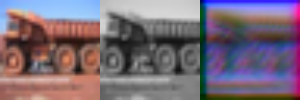

epoch 2001
gen loss: -204.96560668945312
disc loss: 487.6134338378906
epoch 2002
gen loss: -220.3709716796875
disc loss: 475.38690185546875
epoch 2003
gen loss: -201.26107788085938
disc loss: 461.9552001953125
epoch 2004
gen loss: -212.1268310546875
disc loss: 457.333740234375
epoch 2005
gen loss: -193.7480010986328
disc loss: 532.1043701171875
epoch 2006
gen loss: -205.76480102539062
disc loss: 484.60833740234375
epoch 2007
gen loss: -203.27340698242188
disc loss: 464.9957580566406
epoch 2008
gen loss: -191.36363220214844
disc loss: 413.6123962402344
epoch 2009
gen loss: -210.62188720703125
disc loss: 466.50201416015625
epoch 2010
gen loss: -202.81153869628906
disc loss: 445.0271911621094
epoch 2011
gen loss: -186.87860107421875
disc loss: 513.8425903320312
epoch 2012
gen loss: -193.30307006835938
disc loss: 446.4125671386719
epoch 2013
gen loss: -201.21946716308594
disc loss: 493.8489990234375
epoch 2014
gen loss: -191.25555419921875
disc loss: 457.40264892578125
epoch 2015
gen loss:

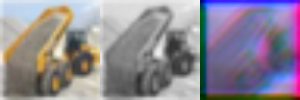

epoch 2101
gen loss: -162.5445556640625
disc loss: 444.5767517089844
epoch 2102
gen loss: -159.9037322998047
disc loss: 454.58319091796875
epoch 2103
gen loss: -157.07667541503906
disc loss: 396.4857177734375
epoch 2104
gen loss: -167.21974182128906
disc loss: 385.97412109375
epoch 2105
gen loss: -174.78692626953125
disc loss: 447.6722106933594
epoch 2106
gen loss: -157.0311279296875
disc loss: 402.1353454589844
epoch 2107
gen loss: -155.35459899902344
disc loss: 427.9082946777344
epoch 2108
gen loss: -163.47142028808594
disc loss: 428.4851989746094
epoch 2109
gen loss: -157.13999938964844
disc loss: 381.1083068847656
epoch 2110
gen loss: -161.89852905273438
disc loss: 420.4960021972656
epoch 2111
gen loss: -156.2446746826172
disc loss: 403.7857666015625
epoch 2112
gen loss: -164.34323120117188
disc loss: 450.75982666015625
epoch 2113
gen loss: -161.15618896484375
disc loss: 408.06494140625
epoch 2114
gen loss: -162.65975952148438
disc loss: 409.79815673828125
epoch 2115
gen loss: -155

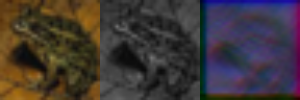

epoch 2201
gen loss: -177.5872039794922
disc loss: 340.1868896484375
epoch 2202
gen loss: -167.2590789794922
disc loss: 330.87030029296875
epoch 2203
gen loss: -164.334228515625
disc loss: 362.65869140625
epoch 2204
gen loss: -157.9901885986328
disc loss: 323.0072021484375
epoch 2205
gen loss: -159.41432189941406
disc loss: 354.67987060546875
epoch 2206
gen loss: -163.31149291992188
disc loss: 321.6312255859375
epoch 2207
gen loss: -163.4788360595703
disc loss: 330.371337890625
epoch 2208
gen loss: -162.49049377441406
disc loss: 315.5159912109375
epoch 2209
gen loss: -159.12054443359375
disc loss: 346.0641784667969
epoch 2210
gen loss: -161.171142578125
disc loss: 324.5985412597656
epoch 2211
gen loss: -151.63571166992188
disc loss: 333.99798583984375
epoch 2212
gen loss: -157.87347412109375
disc loss: 312.5152587890625
epoch 2213
gen loss: -152.21319580078125
disc loss: 312.2598876953125
epoch 2214
gen loss: -156.68267822265625
disc loss: 330.7147216796875
epoch 2215
gen loss: -144.61

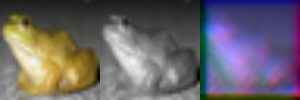

epoch 2301
gen loss: -109.297607421875
disc loss: 334.88214111328125
epoch 2302
gen loss: -99.34016418457031
disc loss: 253.02989196777344
epoch 2303
gen loss: -97.81041717529297
disc loss: 309.98883056640625
epoch 2304
gen loss: -103.38995361328125
disc loss: 292.5471496582031
epoch 2305
gen loss: -106.40890502929688
disc loss: 281.5747375488281
epoch 2306
gen loss: -98.79125213623047
disc loss: 291.6990966796875
epoch 2307
gen loss: -104.55199432373047
disc loss: 281.0890808105469
epoch 2308
gen loss: -114.1686019897461
disc loss: 278.1113586425781
epoch 2309
gen loss: -107.34329986572266
disc loss: 306.301025390625
epoch 2310
gen loss: -111.98578643798828
disc loss: 302.8345031738281
epoch 2311
gen loss: -108.63306427001953
disc loss: 274.3343200683594
epoch 2312
gen loss: -100.75271606445312
disc loss: 281.58184814453125
epoch 2313
gen loss: -109.12245178222656
disc loss: 318.7959289550781
epoch 2314
gen loss: -100.83857727050781
disc loss: 277.9267578125
epoch 2315
gen loss: -101.

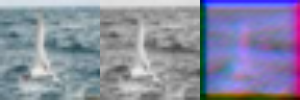

epoch 2401
gen loss: -94.11997985839844
disc loss: 245.2398681640625
epoch 2402
gen loss: -84.67584228515625
disc loss: 246.6466064453125
epoch 2403
gen loss: -97.41883850097656
disc loss: 243.6973876953125
epoch 2404
gen loss: -90.0957260131836
disc loss: 253.584228515625
epoch 2405
gen loss: -96.56879425048828
disc loss: 233.67308044433594
epoch 2406
gen loss: -91.26394653320312
disc loss: 252.76287841796875
epoch 2407
gen loss: -94.79559326171875
disc loss: 239.7908935546875
epoch 2408
gen loss: -96.7431640625
disc loss: 244.94033813476562
epoch 2409
gen loss: -98.4019775390625
disc loss: 258.4647521972656
epoch 2410
gen loss: -97.7147445678711
disc loss: 259.7824401855469
epoch 2411
gen loss: -94.44400024414062
disc loss: 231.1578826904297
epoch 2412
gen loss: -97.60877227783203
disc loss: 247.56939697265625
epoch 2413
gen loss: -103.18512725830078
disc loss: 244.97625732421875
epoch 2414
gen loss: -101.2882308959961
disc loss: 236.13449096679688
epoch 2415
gen loss: -103.953804016

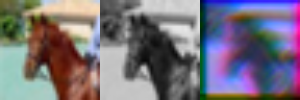

epoch 2501
gen loss: -72.78484344482422
disc loss: 217.2948760986328
epoch 2502
gen loss: -78.22550201416016
disc loss: 235.61395263671875
epoch 2503
gen loss: -74.1670913696289
disc loss: 213.4176788330078
epoch 2504
gen loss: -74.01301574707031
disc loss: 207.3973846435547
epoch 2505
gen loss: -77.02127838134766
disc loss: 213.3438720703125
epoch 2506
gen loss: -82.94198608398438
disc loss: 215.56991577148438
epoch 2507
gen loss: -79.59588623046875
disc loss: 201.0874481201172
epoch 2508
gen loss: -69.36865997314453
disc loss: 202.0469970703125
epoch 2509
gen loss: -74.45108032226562
disc loss: 210.27334594726562
epoch 2510
gen loss: -78.67901611328125
disc loss: 216.84425354003906
epoch 2511
gen loss: -77.19013214111328
disc loss: 211.91136169433594
epoch 2512
gen loss: -78.48943328857422
disc loss: 210.8558807373047
epoch 2513
gen loss: -82.29713439941406
disc loss: 211.9425048828125
epoch 2514
gen loss: -75.30671691894531
disc loss: 205.5358428955078
epoch 2515
gen loss: -75.71109

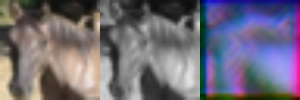

epoch 2601
gen loss: -66.55799865722656
disc loss: 186.1206817626953
epoch 2602
gen loss: -62.253692626953125
disc loss: 191.25379943847656
epoch 2603
gen loss: -69.67088317871094
disc loss: 170.86810302734375
epoch 2604
gen loss: -61.95974349975586
disc loss: 183.55397033691406
epoch 2605
gen loss: -60.46814727783203
disc loss: 183.74948120117188
epoch 2606
gen loss: -66.20899963378906
disc loss: 174.04522705078125
epoch 2607
gen loss: -65.09771728515625
disc loss: 182.22544860839844
epoch 2608
gen loss: -71.8034896850586
disc loss: 188.9600067138672
epoch 2609
gen loss: -60.09574508666992
disc loss: 169.9856414794922
epoch 2610
gen loss: -63.66584777832031
disc loss: 169.45071411132812
epoch 2611
gen loss: -64.41490173339844
disc loss: 179.91949462890625
epoch 2612
gen loss: -60.757591247558594
disc loss: 170.13861083984375
epoch 2613
gen loss: -60.685638427734375
disc loss: 164.68251037597656
epoch 2614
gen loss: -67.58235168457031
disc loss: 185.4217529296875
epoch 2615
gen loss: -

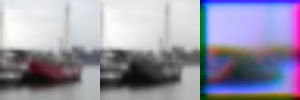

epoch 2701
gen loss: -62.38286590576172
disc loss: 152.63304138183594
epoch 2702
gen loss: -55.17351531982422
disc loss: 147.80177307128906
epoch 2703
gen loss: -60.834312438964844
disc loss: 168.48402404785156
epoch 2704
gen loss: -55.32762908935547
disc loss: 162.16049194335938
epoch 2705
gen loss: -57.2648811340332
disc loss: 158.60476684570312
epoch 2706
gen loss: -61.219146728515625
disc loss: 152.40911865234375
epoch 2707
gen loss: -53.93770217895508
disc loss: 148.58531188964844
epoch 2708
gen loss: -62.16133117675781
disc loss: 151.4529266357422
epoch 2709
gen loss: -57.2734260559082
disc loss: 155.13156127929688
epoch 2710
gen loss: -56.5353889465332
disc loss: 145.4618682861328
epoch 2711
gen loss: -56.76970291137695
disc loss: 149.23342895507812
epoch 2712
gen loss: -51.617637634277344
disc loss: 156.49098205566406
epoch 2713
gen loss: -55.93256378173828
disc loss: 165.28872680664062
epoch 2714
gen loss: -59.455223083496094
disc loss: 161.79824829101562
epoch 2715
gen loss: 

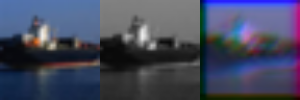

epoch 2801
gen loss: -53.16182327270508
disc loss: 143.91966247558594
epoch 2802
gen loss: -51.01005554199219
disc loss: 135.82823181152344
epoch 2803
gen loss: -48.412601470947266
disc loss: 129.4868621826172
epoch 2804
gen loss: -52.276763916015625
disc loss: 137.56625366210938
epoch 2805
gen loss: -57.704036712646484
disc loss: 150.29672241210938
epoch 2806
gen loss: -45.92105484008789
disc loss: 135.07711791992188
epoch 2807
gen loss: -49.84311294555664
disc loss: 134.24815368652344
epoch 2808
gen loss: -53.868099212646484
disc loss: 134.48036193847656
epoch 2809
gen loss: -47.31684875488281
disc loss: 123.66337585449219
epoch 2810
gen loss: -46.7708740234375
disc loss: 127.95812225341797
epoch 2811
gen loss: -51.44586181640625
disc loss: 133.83270263671875
epoch 2812
gen loss: -42.817527770996094
disc loss: 129.64256286621094
epoch 2813
gen loss: -45.62751388549805
disc loss: 139.02145385742188
epoch 2814
gen loss: -47.796348571777344
disc loss: 125.0704345703125
epoch 2815
gen lo

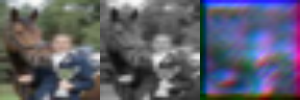

epoch 2901
gen loss: -43.78923034667969
disc loss: 113.87115478515625
epoch 2902
gen loss: -43.155975341796875
disc loss: 118.66629028320312
epoch 2903
gen loss: -48.11668395996094
disc loss: 121.2057876586914
epoch 2904
gen loss: -41.44285202026367
disc loss: 116.2244873046875
epoch 2905
gen loss: -40.6083869934082
disc loss: 119.80199432373047
epoch 2906
gen loss: -41.458648681640625
disc loss: 123.52847290039062
epoch 2907
gen loss: -38.12687683105469
disc loss: 115.7814712524414
epoch 2908
gen loss: -48.95415496826172
disc loss: 119.99691772460938
epoch 2909
gen loss: -40.287967681884766
disc loss: 111.26197052001953
epoch 2910
gen loss: -45.409141540527344
disc loss: 134.92965698242188
epoch 2911
gen loss: -45.418243408203125
disc loss: 124.82911682128906
epoch 2912
gen loss: -40.52449035644531
disc loss: 105.4241943359375
epoch 2913
gen loss: -47.91543960571289
disc loss: 121.38219451904297
epoch 2914
gen loss: -42.64011001586914
disc loss: 113.48928833007812
epoch 2915
gen loss:

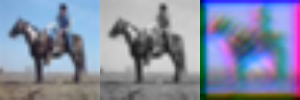

epoch 3001
gen loss: -35.80046081542969
disc loss: 96.8516616821289
epoch 3002
gen loss: -38.257728576660156
disc loss: 104.4183349609375
epoch 3003
gen loss: -33.40616226196289
disc loss: 99.88446807861328
epoch 3004
gen loss: -36.01059341430664
disc loss: 104.16434478759766
epoch 3005
gen loss: -36.18392562866211
disc loss: 102.55569458007812
epoch 3006
gen loss: -37.932456970214844
disc loss: 99.03902435302734
epoch 3007
gen loss: -37.819053649902344
disc loss: 100.06477355957031
epoch 3008
gen loss: -39.72142791748047
disc loss: 98.33570861816406
epoch 3009
gen loss: -35.273719787597656
disc loss: 91.5844497680664
epoch 3010
gen loss: -33.130462646484375
disc loss: 98.89244842529297
epoch 3011
gen loss: -35.4857177734375
disc loss: 102.6141128540039
epoch 3012
gen loss: -36.4935302734375
disc loss: 105.65631866455078
epoch 3013
gen loss: -37.300323486328125
disc loss: 110.1397705078125
epoch 3014
gen loss: -40.61568832397461
disc loss: 103.13714599609375
epoch 3015
gen loss: -34.73

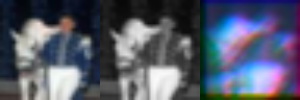

epoch 3101
gen loss: -28.136919021606445
disc loss: 85.3265609741211
epoch 3102
gen loss: -33.35731887817383
disc loss: 97.03208923339844
epoch 3103
gen loss: -34.3875846862793
disc loss: 90.19486999511719
epoch 3104
gen loss: -33.20832824707031
disc loss: 86.85576629638672
epoch 3105
gen loss: -32.755126953125
disc loss: 95.110595703125
epoch 3106
gen loss: -32.52302551269531
disc loss: 89.57667541503906
epoch 3107
gen loss: -31.592639923095703
disc loss: 83.42860412597656
epoch 3108
gen loss: -31.16390609741211
disc loss: 92.56568908691406
epoch 3109
gen loss: -28.832632064819336
disc loss: 83.31890106201172
epoch 3110
gen loss: -31.892301559448242
disc loss: 91.23869323730469
epoch 3111
gen loss: -30.6568603515625
disc loss: 94.1641616821289
epoch 3112
gen loss: -31.596498489379883
disc loss: 89.45001983642578
epoch 3113
gen loss: -33.59251403808594
disc loss: 87.9422607421875
epoch 3114
gen loss: -31.297536849975586
disc loss: 90.36058044433594
epoch 3115
gen loss: -37.755779266357

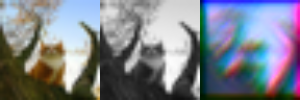

epoch 3201
gen loss: -31.116792678833008
disc loss: 82.76244354248047
epoch 3202
gen loss: -28.703683853149414
disc loss: 75.56310272216797
epoch 3203
gen loss: -30.214839935302734
disc loss: 82.41553497314453
epoch 3204
gen loss: -31.612775802612305
disc loss: 80.00428009033203
epoch 3205
gen loss: -28.299623489379883
disc loss: 76.91786193847656
epoch 3206
gen loss: -28.475006103515625
disc loss: 77.68427276611328
epoch 3207
gen loss: -27.110435485839844
disc loss: 77.40206909179688
epoch 3208
gen loss: -30.80276870727539
disc loss: 70.54685974121094
epoch 3209
gen loss: -28.68902587890625
disc loss: 75.36454772949219
epoch 3210
gen loss: -27.32054901123047
disc loss: 77.39665985107422
epoch 3211
gen loss: -31.56720733642578
disc loss: 76.78776550292969
epoch 3212
gen loss: -26.561750411987305
disc loss: 67.00566101074219
epoch 3213
gen loss: -29.294221878051758
disc loss: 78.26966857910156
epoch 3214
gen loss: -28.294532775878906
disc loss: 79.53312683105469
epoch 3215
gen loss: -28

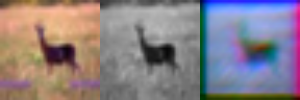

epoch 3301
gen loss: -25.995912551879883
disc loss: 67.01327514648438
epoch 3302
gen loss: -23.86397361755371
disc loss: 82.08562469482422
epoch 3303
gen loss: -23.30780029296875
disc loss: 67.75459289550781
epoch 3304
gen loss: -29.409395217895508
disc loss: 80.09782409667969
epoch 3305
gen loss: -24.791208267211914
disc loss: 62.09758758544922
epoch 3306
gen loss: -28.621707916259766
disc loss: 69.41500091552734
epoch 3307
gen loss: -27.578079223632812
disc loss: 66.07717895507812
epoch 3308
gen loss: -27.51154136657715
disc loss: 69.67516326904297
epoch 3309
gen loss: -27.560848236083984
disc loss: 69.86930847167969
epoch 3310
gen loss: -30.23542022705078
disc loss: 76.94984436035156
epoch 3311
gen loss: -29.964492797851562
disc loss: 72.73947143554688
epoch 3312
gen loss: -28.746416091918945
disc loss: 69.27509307861328
epoch 3313
gen loss: -23.264665603637695
disc loss: 64.80184173583984
epoch 3314
gen loss: -28.03157615661621
disc loss: 72.49543762207031
epoch 3315
gen loss: -21.

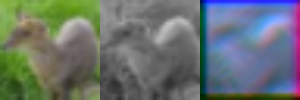

epoch 3401
gen loss: -23.664628982543945
disc loss: 65.82029724121094
epoch 3402
gen loss: -23.2003231048584
disc loss: 58.952457427978516
epoch 3403
gen loss: -20.404766082763672
disc loss: 52.18975830078125
epoch 3404
gen loss: -19.960285186767578
disc loss: 59.704227447509766
epoch 3405
gen loss: -22.435565948486328
disc loss: 63.98176956176758
epoch 3406
gen loss: -22.86256217956543
disc loss: 63.183197021484375
epoch 3407
gen loss: -21.796091079711914
disc loss: 63.20148468017578
epoch 3408
gen loss: -20.061010360717773
disc loss: 64.15152740478516
epoch 3409
gen loss: -23.72894859313965
disc loss: 66.87010192871094
epoch 3410
gen loss: -22.906150817871094
disc loss: 63.414451599121094
epoch 3411
gen loss: -21.303447723388672
disc loss: 72.76514434814453
epoch 3412
gen loss: -18.828121185302734
disc loss: 54.932674407958984
epoch 3413
gen loss: -19.622272491455078
disc loss: 59.8927001953125
epoch 3414
gen loss: -22.100101470947266
disc loss: 79.36245727539062
epoch 3415
gen loss:

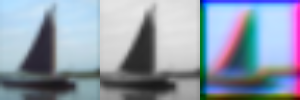

epoch 3501
gen loss: -22.33111000061035
disc loss: 60.72737121582031
epoch 3502
gen loss: -16.657724380493164
disc loss: 55.15065002441406
epoch 3503
gen loss: -21.354778289794922
disc loss: 56.56916046142578
epoch 3504
gen loss: -19.753475189208984
disc loss: 51.44050598144531
epoch 3505
gen loss: -25.157629013061523
disc loss: 55.938262939453125
epoch 3506
gen loss: -20.00606346130371
disc loss: 56.085601806640625
epoch 3507
gen loss: -17.314254760742188
disc loss: 48.31890106201172
epoch 3508
gen loss: -20.313095092773438
disc loss: 49.824256896972656
epoch 3509
gen loss: -22.170007705688477
disc loss: 56.80497741699219
epoch 3510
gen loss: -18.75893783569336
disc loss: 56.92573165893555
epoch 3511
gen loss: -18.3659725189209
disc loss: 49.52559280395508
epoch 3512
gen loss: -19.456857681274414
disc loss: 54.8088493347168
epoch 3513
gen loss: -20.359771728515625
disc loss: 64.26193237304688
epoch 3514
gen loss: -22.705793380737305
disc loss: 60.89102554321289
epoch 3515
gen loss: -2

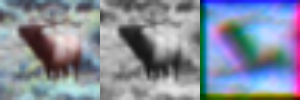

epoch 3601
gen loss: -19.287179946899414
disc loss: 54.39546203613281
epoch 3602
gen loss: -20.828168869018555
disc loss: 57.39240646362305
epoch 3603
gen loss: -15.964353561401367
disc loss: 49.482421875
epoch 3604
gen loss: -16.209938049316406
disc loss: 47.00263214111328
epoch 3605
gen loss: -20.7711181640625
disc loss: 50.90443801879883
epoch 3606
gen loss: -15.988972663879395
disc loss: 45.527862548828125
epoch 3607
gen loss: -18.518327713012695
disc loss: 52.79220199584961
epoch 3608
gen loss: -17.899089813232422
disc loss: 52.852970123291016
epoch 3609
gen loss: -16.40383529663086
disc loss: 44.672000885009766
epoch 3610
gen loss: -19.29967498779297
disc loss: 49.6856803894043
epoch 3611
gen loss: -17.169845581054688
disc loss: 49.99861526489258
epoch 3612
gen loss: -17.83683967590332
disc loss: 52.300445556640625
epoch 3613
gen loss: -14.046849250793457
disc loss: 59.43532180786133
epoch 3614
gen loss: -20.831527709960938
disc loss: 43.044795989990234
epoch 3615
gen loss: -15.6

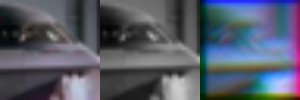

epoch 3701
gen loss: -15.165266990661621
disc loss: 45.178592681884766
epoch 3702
gen loss: -18.296728134155273
disc loss: 56.00557327270508
epoch 3703
gen loss: -15.732721328735352
disc loss: 42.866981506347656
epoch 3704
gen loss: -18.133756637573242
disc loss: 49.11980438232422
epoch 3705
gen loss: -18.047710418701172
disc loss: 48.21696472167969
epoch 3706
gen loss: -15.317192077636719
disc loss: 44.909881591796875
epoch 3707
gen loss: -18.67196273803711
disc loss: 52.94902801513672
epoch 3708
gen loss: -17.66607666015625
disc loss: 49.573875427246094
epoch 3709
gen loss: -17.64288902282715
disc loss: 47.26460266113281
epoch 3710
gen loss: -14.058389663696289
disc loss: 46.762359619140625
epoch 3711
gen loss: -17.386959075927734
disc loss: 46.17810821533203
epoch 3712
gen loss: -19.79168701171875
disc loss: 48.13694763183594
epoch 3713
gen loss: -13.604230880737305
disc loss: 44.7138557434082
epoch 3714
gen loss: -17.416650772094727
disc loss: 46.56173324584961
epoch 3715
gen loss:

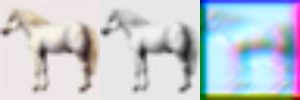

epoch 3801
gen loss: -15.860143661499023
disc loss: 45.81742858886719
epoch 3802
gen loss: -15.08047103881836
disc loss: 39.09516525268555
epoch 3803
gen loss: -14.336342811584473
disc loss: 40.85768127441406
epoch 3804
gen loss: -15.798701286315918
disc loss: 42.709686279296875
epoch 3805
gen loss: -15.811495780944824
disc loss: 42.73686981201172
epoch 3806
gen loss: -16.47756004333496
disc loss: 43.175933837890625
epoch 3807
gen loss: -18.40949821472168
disc loss: 50.19157409667969
epoch 3808
gen loss: -10.891637802124023
disc loss: 42.12019729614258
epoch 3809
gen loss: -15.072871208190918
disc loss: 40.934104919433594
epoch 3810
gen loss: -15.015973091125488
disc loss: 45.931907653808594
epoch 3811
gen loss: -12.669134140014648
disc loss: 36.79014205932617
epoch 3812
gen loss: -14.2808837890625
disc loss: 42.514198303222656
epoch 3813
gen loss: -10.933734893798828
disc loss: 36.605438232421875
epoch 3814
gen loss: -12.815275192260742
disc loss: 42.37512969970703
epoch 3815
gen loss

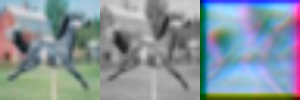

epoch 3901
gen loss: -13.901823043823242
disc loss: 44.34502029418945
epoch 3902
gen loss: -12.048421859741211
disc loss: 37.82096862792969
epoch 3903
gen loss: -12.908489227294922
disc loss: 41.480751037597656
epoch 3904
gen loss: -14.878595352172852
disc loss: 41.19569778442383
epoch 3905
gen loss: -15.587879180908203
disc loss: 44.093727111816406
epoch 3906
gen loss: -12.770339012145996
disc loss: 36.71681213378906
epoch 3907
gen loss: -11.698925018310547
disc loss: 48.442481994628906
epoch 3908
gen loss: -12.46895694732666
disc loss: 39.31795120239258
epoch 3909
gen loss: -17.194507598876953
disc loss: 42.36866760253906
epoch 3910
gen loss: -12.022917747497559
disc loss: 43.15543746948242
epoch 3911
gen loss: -11.532682418823242
disc loss: 37.900299072265625
epoch 3912
gen loss: -14.649572372436523
disc loss: 41.26578140258789
epoch 3913
gen loss: -11.461931228637695
disc loss: 35.05684280395508
epoch 3914
gen loss: -11.796299934387207
disc loss: 34.75840759277344
epoch 3915
gen lo

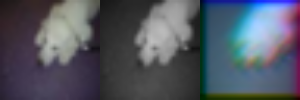

epoch 4001
gen loss: -13.533293724060059
disc loss: 39.052490234375
epoch 4002
gen loss: -11.529803276062012
disc loss: 36.824920654296875
epoch 4003
gen loss: -12.408693313598633
disc loss: 37.01008224487305
epoch 4004
gen loss: -15.577412605285645
disc loss: 41.60081481933594
epoch 4005
gen loss: -13.685086250305176
disc loss: 37.19894027709961
epoch 4006
gen loss: -11.01169490814209
disc loss: 37.36309814453125
epoch 4007
gen loss: -15.912569046020508
disc loss: 35.85686492919922
epoch 4008
gen loss: -12.771503448486328
disc loss: 39.80670166015625
epoch 4009
gen loss: -12.29111099243164
disc loss: 33.421566009521484
epoch 4010
gen loss: -8.392499923706055
disc loss: 28.91793441772461
epoch 4011
gen loss: -10.261905670166016
disc loss: 34.503692626953125
epoch 4012
gen loss: -10.764513969421387
disc loss: 36.8405876159668
epoch 4013
gen loss: -10.050824165344238
disc loss: 32.713619232177734
epoch 4014
gen loss: -12.615795135498047
disc loss: 37.935096740722656
epoch 4015
gen loss: 

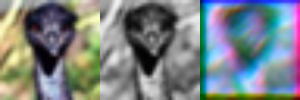

epoch 4101
gen loss: -13.87777328491211
disc loss: 38.09211730957031
epoch 4102
gen loss: -13.816244125366211
disc loss: 37.14883041381836
epoch 4103
gen loss: -12.703304290771484
disc loss: 28.094093322753906
epoch 4104
gen loss: -10.934288024902344
disc loss: 36.298030853271484
epoch 4105
gen loss: -12.433701515197754
disc loss: 35.76734924316406
epoch 4106
gen loss: -11.73353385925293
disc loss: 36.674461364746094
epoch 4107
gen loss: -12.466540336608887
disc loss: 36.03973388671875
epoch 4108
gen loss: -9.474700927734375
disc loss: 31.555179595947266
epoch 4109
gen loss: -10.579296112060547
disc loss: 50.75164794921875
epoch 4110
gen loss: -13.151734352111816
disc loss: 34.26232147216797
epoch 4111
gen loss: -16.063764572143555
disc loss: 37.592002868652344
epoch 4112
gen loss: -12.583433151245117
disc loss: 33.89738845825195
epoch 4113
gen loss: -10.271917343139648
disc loss: 33.50206756591797
epoch 4114
gen loss: -10.830612182617188
disc loss: 32.830604553222656
epoch 4115
gen lo

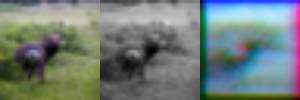

epoch 4201
gen loss: -10.451983451843262
disc loss: 33.50918197631836
epoch 4202
gen loss: -14.386077880859375
disc loss: 38.42766571044922
epoch 4203
gen loss: -10.498483657836914
disc loss: 32.03585433959961
epoch 4204
gen loss: -10.3850736618042
disc loss: 32.40790557861328
epoch 4205
gen loss: -10.243269920349121
disc loss: 41.71195983886719
epoch 4206
gen loss: -12.213380813598633
disc loss: 34.775596618652344
epoch 4207
gen loss: -11.854143142700195
disc loss: 33.975215911865234
epoch 4208
gen loss: -10.542407035827637
disc loss: 31.625595092773438
epoch 4209
gen loss: -9.672916412353516
disc loss: 25.194561004638672
epoch 4210
gen loss: -10.871553421020508
disc loss: 33.88077926635742
epoch 4211
gen loss: -10.139641761779785
disc loss: 33.6187744140625
epoch 4212
gen loss: -7.151291847229004
disc loss: 26.310461044311523
epoch 4213
gen loss: -10.0954008102417
disc loss: 39.95936965942383
epoch 4214
gen loss: -9.26997184753418
disc loss: 32.279441833496094
epoch 4215
gen loss: -1

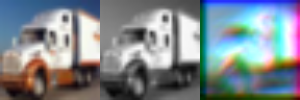

epoch 4301
gen loss: -11.229596138000488
disc loss: 36.37039566040039
epoch 4302
gen loss: -7.981895446777344
disc loss: 29.691486358642578
epoch 4303
gen loss: -11.354056358337402
disc loss: 35.13847351074219
epoch 4304
gen loss: -10.21226978302002
disc loss: 32.51707077026367
epoch 4305
gen loss: -11.721269607543945
disc loss: 36.874019622802734
epoch 4306
gen loss: -10.894582748413086
disc loss: 33.7668342590332
epoch 4307
gen loss: -10.299572944641113
disc loss: 33.83121109008789
epoch 4308
gen loss: -9.830144882202148
disc loss: 34.105690002441406
epoch 4309
gen loss: -11.299510955810547
disc loss: 34.58662033081055
epoch 4310
gen loss: -8.604207038879395
disc loss: 24.725730895996094
epoch 4311
gen loss: -10.50144100189209
disc loss: 28.173877716064453
epoch 4312
gen loss: -11.848047256469727
disc loss: 33.451194763183594
epoch 4313
gen loss: -8.34817886352539
disc loss: 25.430583953857422
epoch 4314
gen loss: -7.705953121185303
disc loss: 30.63261604309082
epoch 4315
gen loss: -

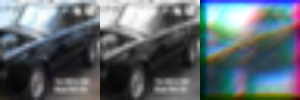

epoch 4401
gen loss: -10.645548820495605
disc loss: 30.385234832763672
epoch 4402
gen loss: -7.367338180541992
disc loss: 28.415700912475586
epoch 4403
gen loss: -10.864768981933594
disc loss: 31.677860260009766
epoch 4404
gen loss: -7.888829708099365
disc loss: 30.654943466186523
epoch 4405
gen loss: -9.481886863708496
disc loss: 31.25086784362793
epoch 4406
gen loss: -9.93151569366455
disc loss: 32.635318756103516
epoch 4407
gen loss: -8.372989654541016
disc loss: 26.609458923339844
epoch 4408
gen loss: -9.282896995544434
disc loss: 29.650413513183594
epoch 4409
gen loss: -10.548348426818848
disc loss: 32.40326690673828
epoch 4410
gen loss: -9.977958679199219
disc loss: 36.851295471191406
epoch 4411
gen loss: -13.074302673339844
disc loss: 33.44498062133789
epoch 4412
gen loss: -9.528127670288086
disc loss: 30.460840225219727
epoch 4413
gen loss: -10.407745361328125
disc loss: 33.9606819152832
epoch 4414
gen loss: -9.495468139648438
disc loss: 28.026756286621094
epoch 4415
gen loss: 

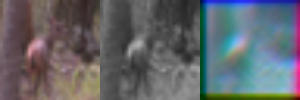

epoch 4501
gen loss: -8.462080955505371
disc loss: 43.70937728881836
epoch 4502
gen loss: -8.879438400268555
disc loss: 32.627708435058594
epoch 4503
gen loss: -9.605306625366211
disc loss: 34.211883544921875
epoch 4504
gen loss: -9.106456756591797
disc loss: 31.162334442138672
epoch 4505
gen loss: -9.307271957397461
disc loss: 35.50115966796875
epoch 4506
gen loss: -9.485464096069336
disc loss: 28.82501983642578
epoch 4507
gen loss: -8.75741958618164
disc loss: 26.194129943847656
epoch 4508
gen loss: -10.668612480163574
disc loss: 31.776079177856445
epoch 4509
gen loss: -7.297612190246582
disc loss: 26.55684471130371
epoch 4510
gen loss: -6.923103332519531
disc loss: 26.017839431762695
epoch 4511
gen loss: -8.659713745117188
disc loss: 28.686126708984375
epoch 4512
gen loss: -10.948638916015625
disc loss: 32.58079528808594
epoch 4513
gen loss: -9.670770645141602
disc loss: 25.90835189819336
epoch 4514
gen loss: -10.536187171936035
disc loss: 24.003704071044922
epoch 4515
gen loss: -10

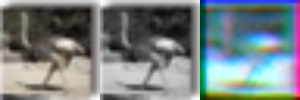

epoch 4601
gen loss: -8.455467224121094
disc loss: 36.22335433959961
epoch 4602
gen loss: -7.8472089767456055
disc loss: 25.323486328125
epoch 4603
gen loss: -10.121757507324219
disc loss: 26.190587997436523
epoch 4604
gen loss: -8.801007270812988
disc loss: 25.83970069885254
epoch 4605
gen loss: -9.350367546081543
disc loss: 29.951324462890625
epoch 4606
gen loss: -7.556956768035889
disc loss: 21.929485321044922
epoch 4607
gen loss: -7.674784183502197
disc loss: 27.653728485107422
epoch 4608
gen loss: -9.198254585266113
disc loss: 33.668113708496094
epoch 4609
gen loss: -10.368538856506348
disc loss: 24.479970932006836
epoch 4610
gen loss: -7.126521110534668
disc loss: 24.953710556030273
epoch 4611
gen loss: -10.398784637451172
disc loss: 28.413864135742188
epoch 4612
gen loss: -9.63013744354248
disc loss: 24.441726684570312
epoch 4613
gen loss: -11.32109546661377
disc loss: 45.735084533691406
epoch 4614
gen loss: -7.648069381713867
disc loss: 27.48897933959961
epoch 4615
gen loss: -1

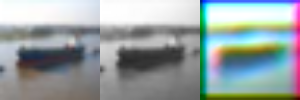

epoch 4701
gen loss: -8.356243133544922
disc loss: 33.48163986206055
epoch 4702
gen loss: -5.808518409729004
disc loss: 30.731006622314453
epoch 4703
gen loss: -9.0365629196167
disc loss: 28.064590454101562
epoch 4704
gen loss: -8.70499038696289
disc loss: 25.449684143066406
epoch 4705
gen loss: -8.20531177520752
disc loss: 25.504940032958984
epoch 4706
gen loss: -7.5161967277526855
disc loss: 21.745412826538086
epoch 4707
gen loss: -7.974599361419678
disc loss: 22.091632843017578
epoch 4708
gen loss: -8.241146087646484
disc loss: 27.70208740234375
epoch 4709
gen loss: -9.664899826049805
disc loss: 28.32142448425293
epoch 4710
gen loss: -7.712588310241699
disc loss: 29.96700668334961
epoch 4711
gen loss: -9.366074562072754
disc loss: 32.98147201538086
epoch 4712
gen loss: -9.617132186889648
disc loss: 25.58057403564453
epoch 4713
gen loss: -7.482621192932129
disc loss: 30.27872657775879
epoch 4714
gen loss: -5.905776023864746
disc loss: 24.396160125732422
epoch 4715
gen loss: -7.972870

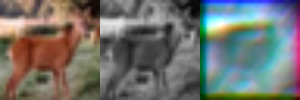

epoch 4801
gen loss: -7.9776411056518555
disc loss: 25.895889282226562
epoch 4802
gen loss: -10.593489646911621
disc loss: 27.969112396240234
epoch 4803
gen loss: -8.732535362243652
disc loss: 32.051727294921875
epoch 4804
gen loss: -6.772374629974365
disc loss: 23.200176239013672
epoch 4805
gen loss: -9.424267768859863
disc loss: 27.858095169067383
epoch 4806
gen loss: -7.760942459106445
disc loss: 22.088918685913086
epoch 4807
gen loss: -7.490622520446777
disc loss: 30.252634048461914
epoch 4808
gen loss: -6.050149440765381
disc loss: 23.499969482421875
epoch 4809
gen loss: -9.991425514221191
disc loss: 28.532764434814453
epoch 4810
gen loss: -9.233246803283691
disc loss: 28.09014320373535
epoch 4811
gen loss: -9.2861909866333
disc loss: 26.113420486450195
epoch 4812
gen loss: -7.964974880218506
disc loss: 27.11676788330078
epoch 4813
gen loss: -8.702142715454102
disc loss: 25.935619354248047
epoch 4814
gen loss: -6.400360107421875
disc loss: 27.343116760253906
epoch 4815
gen loss: -

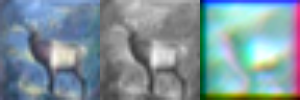

epoch 4901
gen loss: -8.330889701843262
disc loss: 25.43740463256836
epoch 4902
gen loss: -11.286176681518555
disc loss: 28.215526580810547
epoch 4903
gen loss: -7.7238640785217285
disc loss: 27.030899047851562
epoch 4904
gen loss: -8.936359405517578
disc loss: 30.598384857177734
epoch 4905
gen loss: -9.661243438720703
disc loss: 31.738866806030273
epoch 4906
gen loss: -6.636417388916016
disc loss: 22.161128997802734
epoch 4907
gen loss: -8.57369613647461
disc loss: 29.808027267456055
epoch 4908
gen loss: -7.127384662628174
disc loss: 27.811168670654297
epoch 4909
gen loss: -10.763530731201172
disc loss: 27.37046241760254
epoch 4910
gen loss: -9.06509017944336
disc loss: 27.361751556396484
epoch 4911
gen loss: -8.370351791381836
disc loss: 33.619319915771484
epoch 4912
gen loss: -9.533255577087402
disc loss: 26.719440460205078
epoch 4913
gen loss: -8.954082489013672
disc loss: 25.470956802368164
epoch 4914
gen loss: -8.12825870513916
disc loss: 29.391958236694336
epoch 4915
gen loss: -

In [17]:
initial_learning_rate = 1e-5
epochs = 5000
batch_size = 512
gen = generator(batch_size)

learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=epochs, decay_rate=0.9)
optimizer_gen = tf.keras.optimizers.Adam(learning_rate)
optimizer_disc = tf.keras.optimizers.Adam(learning_rate)

G = Generator()
D = Discriminator()

for e_idx in range(epochs):
    print(f"epoch {e_idx}")
    with tf.GradientTape() as tape_gen, tf.GradientTape() as tape_disc:
        tape_gen.watch(G.trainable_variables)
        tape_disc.watch(D.trainable_variables)
        x, y = next(gen)    # gray, color images
        # generate fake images
        Gx = G(x)
        # compute the discriminator values
        Dy = D(y)
        DGx = D(Gx)
        # calculate the losses 
        loss_gen = loss_generator(DGx)
        print(f"gen loss: {tf.reduce_sum(loss_gen).numpy()}")
        tf.debugging.check_numerics(loss_gen, "loss_gen has nan-s")
        loss_disc = loss_discriminator(Dy, DGx)
        print(f"disc loss: {tf.reduce_sum(loss_disc).numpy()}")
        tf.debugging.check_numerics(loss_disc, "loss_disc has nan-s")
        grads_gen = tape_gen.gradient(loss_gen, G.trainable_variables)
        grads_disc = tape_disc.gradient(loss_disc, D.trainable_variables)
    optimizer_gen.apply_gradients(zip(grads_gen, G.trainable_variables))
    optimizer_disc.apply_gradients(zip(grads_disc, D.trainable_variables))
    if e_idx > 0 and e_idx % 100 == 0:
        a = cv2.resize(cv2.cvtColor(y[0], cv2.COLOR_RGB2BGR), (100, 100)) * 255
        b = cv2.resize(cv2.cvtColor(x[0], cv2.COLOR_GRAY2BGR), (100, 100)) * 255
        c = cv2.resize(cv2.cvtColor(Gx[0].numpy(), cv2.COLOR_RGB2BGR), (100, 100)) * 255
        cv2_imshow(np.hstack((a,b,c)))


### Results

For the results one can see that the network definitely learned something and tries to color the images accordingly, however despite the many training iterations (5000 epochs) the network couldn't produce very accurate results. Mainly i impute this bahaviour to the fact that i couldn't find the appropriate generator architecture / loss that could propagate the losses backward for each color channel, not just for the image as a whole.

In short i found that coloring an image is not as trivial as it looks, i would gladly give it another go if had the chance/time.


In [18]:
x,y = next(gen)
fake_imgs = G(x)
fake_imgs.shape

TensorShape([512, 32, 32, 3])

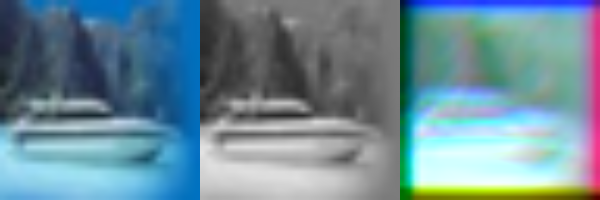

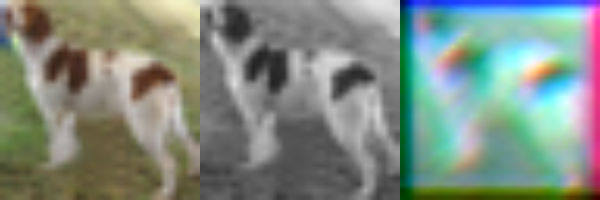

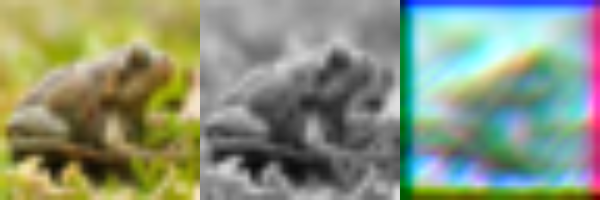

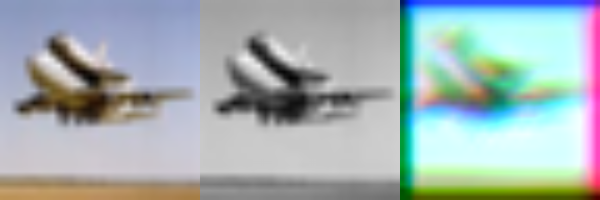

In [19]:
for i in range(4):
    a = cv2.resize(cv2.cvtColor(y[i], cv2.COLOR_RGB2BGR), (200, 200)) * 255
    b = cv2.resize(cv2.cvtColor(x[i], cv2.COLOR_GRAY2BGR), (200, 200)) * 255
    c = cv2.resize(cv2.cvtColor(fake_imgs[i].numpy(), cv2.COLOR_RGB2BGR), (200, 200)) * 255
    cv2_imshow(np.hstack((a,b,c)))